# Imports

In [1]:
 # * Importing Libraries

import vitaldb
import mne
import biosppy 
import hrvanalysis
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
 # * Importing Case

case = 3
sampling_frequency = 512 # Detailed in the documentation of VitalDB
tracks = ['SNUADC/ECG_II', 'BIS/BIS', 'BIS/SQI'] # Select relevant track data from case

data = vitaldb.vital_recs(ipath = case, track_names = tracks, interval = 1/sampling_frequency, return_timestamp = True, return_pandas = True) # Load case data from VitalDB

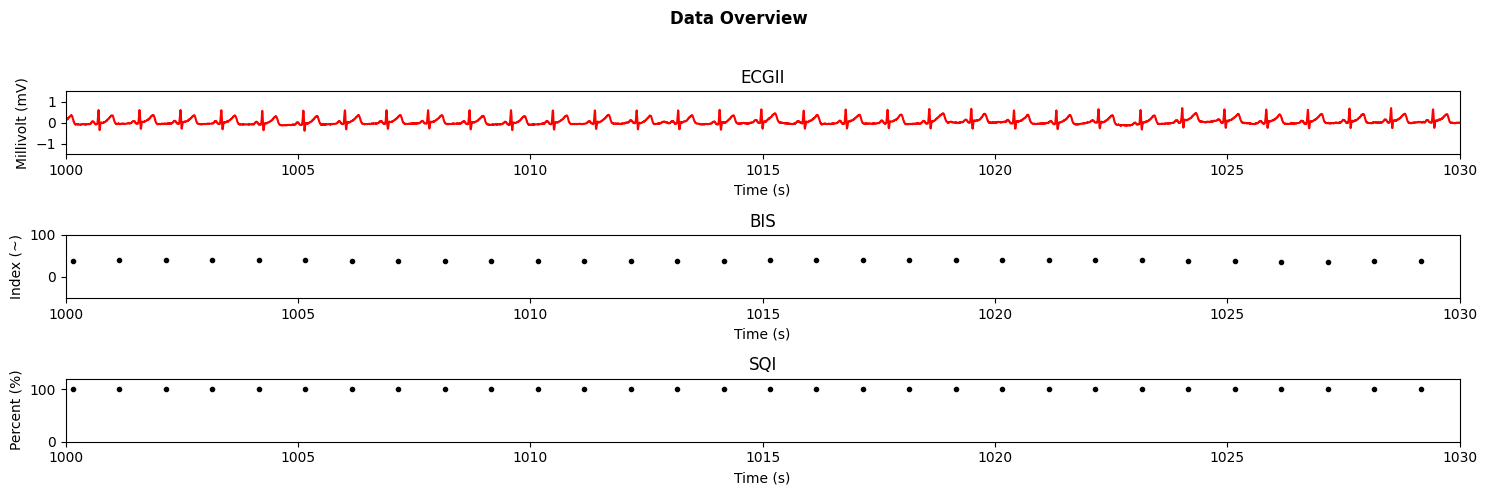

In [3]:
 # * Plotting Track Data

time = data.iloc[:, 0]
ECGII = data.iloc[:, 1]
BIS = data.iloc[:, 2]
SQI = data.iloc[:, 3]

fig, axes = plt.subplots(3, 1, figsize = (15,5))
fig.suptitle('Data Overview \n', fontweight = 'bold')

plt.setp(axes, xlabel = 'Time (s)')
plt.setp(axes, xlim = (1000, 1030))

axes[0].plot(time, ECGII, 'r')
axes[0].set_title('ECGII')
axes[0].set_ylabel('Millivolt (mV)')
axes[0].set_ylim(-1.5,1.5)

axes[1].plot(time, BIS, 'k.')
axes[1].set_title('BIS')
axes[1].set_ylabel('Index (~)')
axes[1].set_ylim(-50,100)

axes[2].plot(time, SQI, 'k.')
axes[2].set_title('SQI')
axes[2].set_ylabel('Percent (%)')
axes[2].set_ylim(0,120)

plt.tight_layout()
plt.show()

# Raw Data

In [4]:
 # * Raw Creation

ECGII_reshaped = np.array(ECGII).reshape(1, -1) / 1e3 # Reshape data and convert to Volts
info = mne.create_info(ch_names = ['ECGII'], sfreq = sampling_frequency, ch_types = ['ecg']) # Creates the metadata for the Raw class
raw = mne.io.RawArray(data = ECGII_reshaped, info = info, verbose = False) # Creates the Raw class for ECG data

display(raw)

<RawArray | 1 x 2249749 (4394.0 s), ~17.2 MB, data loaded>

# Epoch Data

In [5]:
 # * Creating BIS Events

SQI_threshold = 65 # Only BIS values > 65 SQI are used for analysis
window = 120 # Sets the window of the ECG epoch

BIS_events = data[(SQI > SQI_threshold) & (time > window/2) & (time < time.max() - window/2)] # Select data associated with valid BIS values
num_BIS_events = len(BIS_events)

# Preparing and formating the BIS events to be used for epoching 
event_onset_idx = BIS_events.index
event_zeros = np.zeros(num_BIS_events)
event_id = np.ones(num_BIS_events)
events = np.column_stack((event_onset_idx, event_zeros, event_id)).astype(int)

print(f'Number of BIS Events: {num_BIS_events}')
events_df = pd.DataFrame(data = events, columns = ["Onset time (sample)", "Leave Empty", "Event ID"])
events_df.insert(loc = 0, column = 'Onset time (sec)', value = raw.times[event_onset_idx])
events_df.insert(loc = 0, column = 'SQI Value', value = np.array(SQI[event_onset_idx]))
events_df.insert(loc = 0, column = 'BIS Value', value = np.array(BIS[event_onset_idx]))

display(events_df)

Number of BIS Events: 3167


,BIS Value,SQI Value,Onset time (sec),Onset time (sample),Leave Empty,Event ID
0,97.099998,70.500000,60.164062,30804,0,1
1,96.500000,71.199997,61.164062,31316,0,1
2,96.500000,71.199997,62.164062,31828,0,1
3,94.500000,71.199997,63.164062,32340,0,1
4,94.500000,69.900002,64.164062,32852,0,1
...,...,...,...,...,...,...
3162,85.699997,75.599998,3715.179688,1902172,0,1
3163,85.699997,75.599998,3716.179688,1902684,0,1
3164,85.699997,75.000000,3717.179688,1903196,0,1
3165,85.900002,73.699997,3718.179688,1903708,0,1


In [6]:
 # * Generating Epochs

epochs = mne.Epochs(raw = raw, events = events, tmin = -window/2, tmax = window/2, baseline = None, preload = True, verbose = False) # Epoch around BIS events
epochs_original = epochs.copy() # Saves a copy of the original epochs

In [7]:
 # * Dropping NaN

nan_epochs = np.isnan(epochs).any(axis = (1, 2))
nan_epochs_idx = np.where(nan_epochs)[0]

epochs.drop(indices = nan_epochs_idx, reason = 'NaN', verbose = False) # Drop any epoch with NaN values

Number of events,3045
Events,1: 3045
Time range,-60.000 – 60.000 s
Baseline,off


In [8]:
 # * Filtering and Baseline Correcting

l_freq = 1
h_freq = 40    
filter_params = dict(order = 5, ftype = 'butter') 

epochs_filtered = epochs.copy().filter( # Filters the epochs with a 5th order butterworth filter (1.0-40 Hz)
    l_freq = l_freq,
    h_freq = h_freq,
    picks = 'ecg',
    method = 'iir',
    iir_params = filter_params
)

epochs_filtered.apply_baseline((None, None), verbose = True) # Applies a mean baseline correction

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Applying baseline correction (mode: mean)


Number of events,3045
Events,1: 3045
Time range,-60.000 – 60.000 s
Baseline,-60.000 – 60.000 s


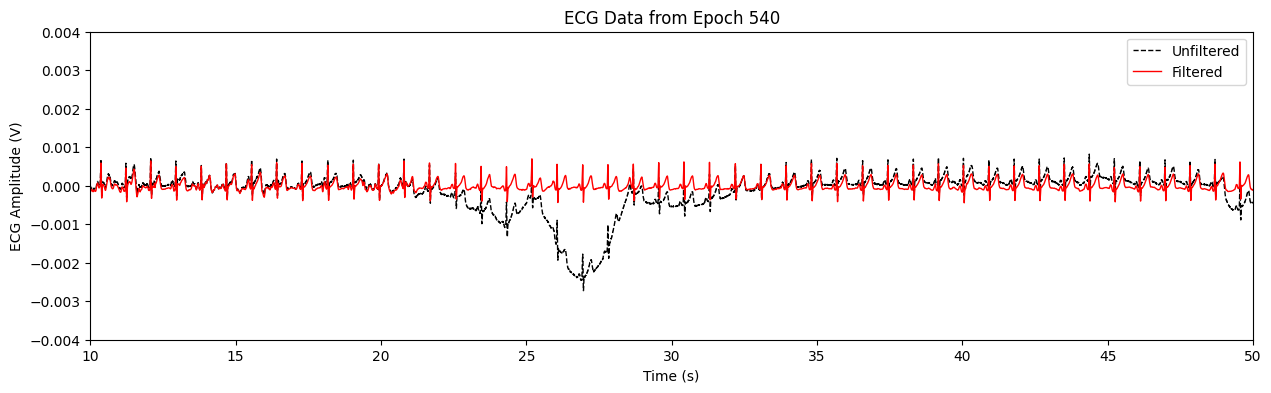

In [9]:
 # * Plotting Unfiltered vs Filtered Signal

epoch_idx = 540
epoch_unfiltered_plotting = epochs[epoch_idx].get_data()[0][0]
epoch_filtered_plotting = epochs_filtered[epoch_idx].get_data()[0][0]
samples_plotting = len(epoch_unfiltered_plotting)
time_plotting = np.arange(samples_plotting) / sampling_frequency

plt.figure(figsize=(15, 4))
plt.plot(time_plotting, epoch_unfiltered_plotting, color='k', linewidth=1, linestyle = '--', label = 'Unfiltered')
plt.plot(time_plotting, epoch_filtered_plotting, color='r', linewidth=1, linestyle = '-', label = 'Filtered')
plt.title(f'ECG Data from Epoch {epoch_idx}')
plt.xlabel('Time (s)')
plt.ylabel('ECG Amplitude (V)')
plt.xlim(10,50)
plt.ylim(-0.004, 0.004)
plt.legend()
plt.show()

Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB



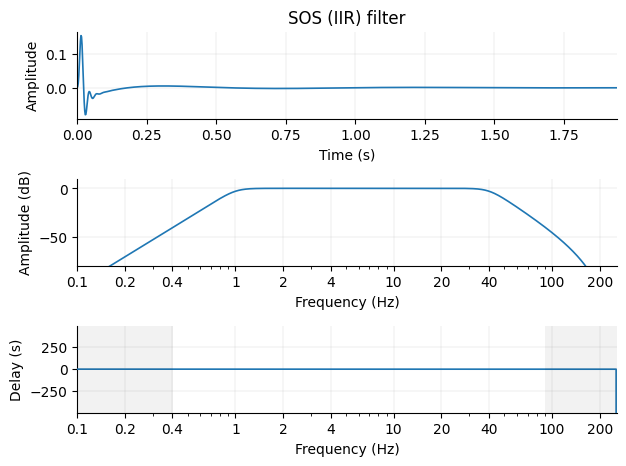

In [10]:
 # * Frequency Response Graph of Filter

IIR_filter  = mne.filter.create_filter(epochs.get_data(), sfreq = sampling_frequency, l_freq = l_freq, h_freq = h_freq, method = 'iir', iir_params = filter_params)
mne.viz.plot_filter(IIR_filter, sfreq = sampling_frequency); # Plots the frequency response graph of the filter used

Median of Peak-to-Peak Amplitude: 0.001194 V
Median Absolute Deviation: 0.000193 V 

Upper Amp Threshold: 0.001676 V
Lower Amp Threshold: 0.000713 V


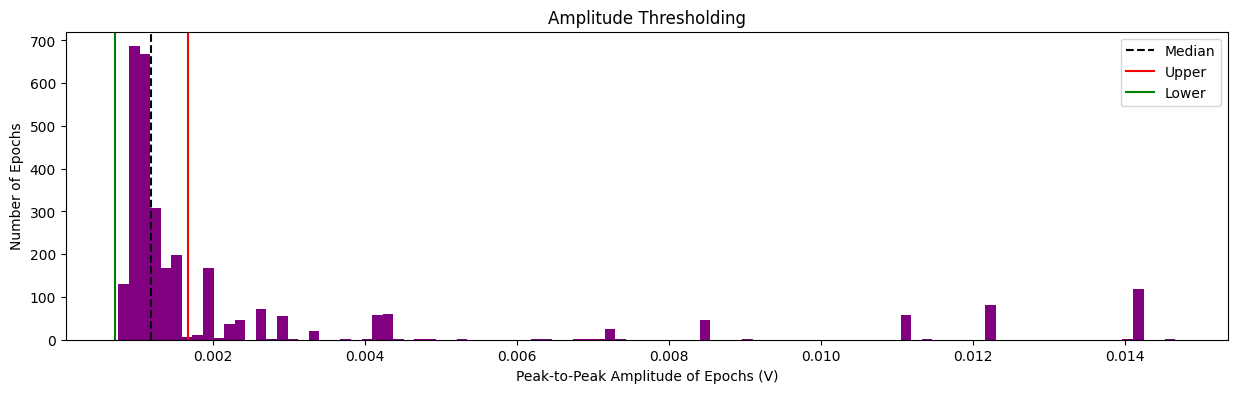

In [11]:
 # * Finding Amplitude Thresholds

def find_MAD_thresholds(ptp_data, threshold_multipiler): # Function for determining the PTP median, PTP median absolute deviation, and upper/lower thresholds
    ptp_median = np.median(ptp_data)
    ptp_deviations = np.abs(ptp_data - ptp_median)
    ptp_MAD = np.median(ptp_deviations)

    upper_thresh =  ptp_median + threshold_multipiler * ptp_MAD
    lower_thresh = ptp_median - threshold_multipiler * ptp_MAD

    if lower_thresh < 0:
        lower_thresh = 0

    return(ptp_median, ptp_MAD, upper_thresh, lower_thresh)

def plot_ptp_hist(ptp_data, median, upper_threshold, lower_threshold, bins, xlim = None): # Plots a histogram of the PTPs, the PTP median, and the upper/lower thresholds
    plt.figure(figsize = (15, 4))
    plt.hist(ptp_data, bins = bins, color = 'purple')
    plt.axvline(median, color = 'k', linestyle = '--', label = 'Median')
    plt.axvline(upper_threshold, color = 'r', linestyle = '-', label = "Upper")
    plt.axvline(lower_threshold, color = 'g', linestyle = '-', label = "Lower" )
    plt.title('Amplitude Thresholding')
    plt.xlabel('Peak-to-Peak Amplitude of Epochs (V)')
    plt.ylabel('Number of Epochs')
    plt.legend()

    if xlim != None:
        plt.xlim(xlim)

ptp = np.ptp(epochs_filtered, axis = (1,2)) # Computes the PTP of each epoch
ptp_median, ptp_MAD, upper_thresh, lower_thresh = find_MAD_thresholds(ptp_data = ptp, threshold_multipiler = 2.5) # Computes the thresholds

print(f'Median of Peak-to-Peak Amplitude: {ptp_median:.6f} V')
print(f'Median Absolute Deviation: {ptp_MAD:.6f} V \n')
print(f'Upper Amp Threshold: {upper_thresh:.6f} V')
print(f'Lower Amp Threshold: {lower_thresh:.6f} V')

plot_ptp_hist(ptp, ptp_median, upper_thresh, lower_thresh, bins = 100)

In [12]:
 # * Applying Amplitude Thresholds

def amp_thresholding(epochs, threshold, type):

    if (type == 'Upper Threshold'):
        exceed_amp = np.where(np.ptp(epochs, axis = (1,2)) > threshold)[0]
        epochs.drop(indices = exceed_amp, reason = 'Exceed Amp Thresh', verbose = False)

    if (type == 'Lower Threshold'):
        below_amp = np.where(np.ptp(epochs, axis = (1,2)) < threshold)[0]
        epochs.drop(indices = below_amp, reason = 'Below Amp Thresh', verbose = False)

amp_thresholding(epochs_filtered, threshold = upper_thresh, type = 'Upper Threshold') # Applies upper amp threshold
amp_thresholding(epochs_filtered, threshold = lower_thresh, type = 'Lower Threshold') # Applies lower amp threshold

In [13]:
 # * Summary of Epochs

num_epochs_initial = len(epochs_original.events)
num_epochs = len(epochs_filtered.events)

dropped_epochs_idx  = np.array([index for index, element in enumerate(epochs_filtered.drop_log) if element != ()])
dropped_epochs_reason = np.array([element for element in epochs_filtered.drop_log if element != ()])
num_epochs_dropped = len(dropped_epochs_idx)
df_dropped = pd.DataFrame({
    'Dropped Index': dropped_epochs_idx.flatten(),
    'Reason': dropped_epochs_reason.flatten()})

dropped_epochs_idx_nan = df_dropped[df_dropped["Reason"] == "NaN"]["Dropped Index"].tolist()
dropped_epochs_idx_exceed = df_dropped[df_dropped["Reason"] == "Exceed Amp Thresh"]["Dropped Index"].tolist()
dropped_epochs_idx_below = df_dropped[df_dropped["Reason"] == "Below Amp Thresh"]["Dropped Index"].tolist()

print(f'Initial Number of Epochs: {num_epochs_initial}')
print(f'Remaining Number of Epochs: {num_epochs}')
print(f'Total Epochs Dropped: {num_epochs_dropped}')
print(f'Percent of Epochs Dropped: {num_epochs_dropped / num_epochs_initial *100 :.2f}%')

display(df_dropped)
print(f'Dropped Epoch Index (x{num_epochs_dropped}): \n{dropped_epochs_idx.tolist()} \n')
print(f'Index Dropped Due to NaN (x{len(dropped_epochs_idx_nan)}): \n{dropped_epochs_idx_nan} \n')
print(f'Index Dropped Due to Exceed Amp (x{len(dropped_epochs_idx_exceed)}): \n{dropped_epochs_idx_exceed} \n')
print(f'Index Dropped Due to Below Amp (x{len(dropped_epochs_idx_below)}): \n{dropped_epochs_idx_below}')

Initial Number of Epochs: 3167
Remaining Number of Epochs: 2162
Total Epochs Dropped: 1005
Percent of Epochs Dropped: 31.73%


,Dropped Index,Reason
0,0,NaN
1,1,NaN
2,148,Exceed Amp Thresh
3,196,Exceed Amp Thresh
4,197,Exceed Amp Thresh
...,...,...
1000,3162,Exceed Amp Thresh
1001,3163,Exceed Amp Thresh
1002,3164,Exceed Amp Thresh
1003,3165,Exceed Amp Thresh


Dropped Epoch Index (x1005): 
[0, 1, 148, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387

# R-Peak, RRI, NNI

In [14]:
 # * Detecting R-Peak Location

epochs_r_peaks_idx = []
for epoch in epochs_filtered: # Determine the indices of the R-peaks within each epoch using a hamilton segmenter
    epoch_data = epoch[0]
    r_peaks_idx = np.array(biosppy.signals.ecg.hamilton_segmenter(signal = epoch_data, sampling_rate = sampling_frequency))
    epochs_r_peaks_idx.append(r_peaks_idx[0])

epochs_r_peaks_times = [array / sampling_frequency for array in epochs_r_peaks_idx] # Converts the R-peak indices into time

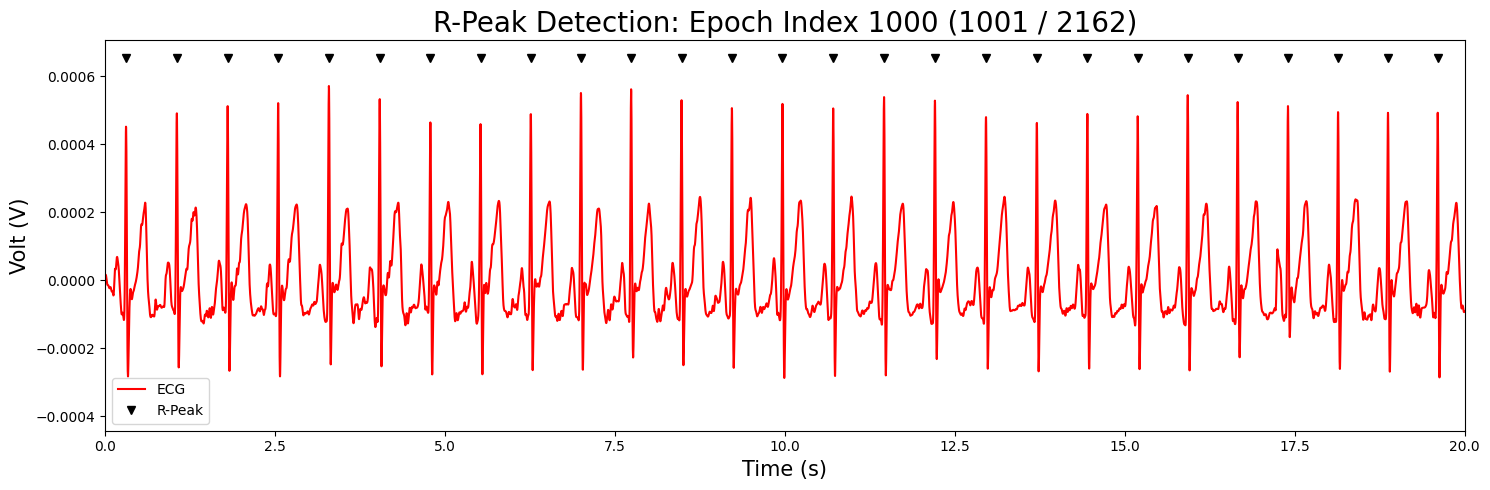

In [15]:
 # * Visualizing R-Peaks

def plot_r_peaks(epoch_idx, xlim):
    ecg_values = epochs_filtered[epoch_idx].get_data()[0][0]
    r_peak_times = epochs_r_peaks_times[epoch_idx]

    plt.figure(figsize = (15, 5))

    num_samples = len(ecg_values)
    duration = num_samples / sampling_frequency
    time_ax = np.linspace(0, duration, num_samples)
    plt.plot(time_ax, ecg_values, 'r', label = 'ECG')

    r_peak_marker = np.zeros(len(r_peak_times)) + ecg_values.max()
    plt.plot(r_peak_times, r_peak_marker, 'kv', label = 'R-Peak')

    plt.title(f'R-Peak Detection: Epoch Index {epoch_idx} ({epoch_idx + 1} / {num_epochs})', fontsize = 20)
    plt.xlim(xlim)

    plt.xlabel('Time (s)', fontsize = 15)
    plt.ylabel('Volt (V)', fontsize = 15)

    plt.legend()
    plt.tight_layout(),
    plt.show()

plot_r_peaks(epoch_idx = 1000, xlim = (0, 20))

In [16]:
 # * Computing RRI 

epochs_rri = []

for epoch in epochs_r_peaks_times: # Computes the RRI for each epoch as the time difference between consecutive R-peaks
	rri = np.diff(epoch)
	epochs_rri.append(rri)

epochs_rri_ms = [array * 1000 for array in epochs_rri] # Converts the RRI from sec into msec

In [17]:
 # * Computing NNI

epochs_nni_ms = []
epochs_outlier_percent = []
epochs_ectopic_percent = []

for epoch in epochs_rri_ms: # Computes the NNI and the percent of outliers and ectopics for each epoch

    epoch_rm_outliers = hrvanalysis.preprocessing.remove_outliers(rr_intervals = epoch, verbose = False)
    epochs_outlier_percent.append(np.sum(np.isnan(epoch_rm_outliers)) / len(epoch_rm_outliers) * 100)
    epoch_rm_outliers_interpolated = hrvanalysis.preprocessing.interpolate_nan_values(rr_intervals = epoch_rm_outliers)
    
    epoch_rm_ectopic = hrvanalysis.preprocessing.remove_ectopic_beats(rr_intervals = epoch_rm_outliers_interpolated, verbose = False)
    epochs_ectopic_percent.append(np.sum(np.isnan(epoch_rm_ectopic)) / len(epoch_rm_ectopic) * 100)
    epoch_rm_ectopic_interpolated = hrvanalysis.preprocessing.interpolate_nan_values(rr_intervals = epoch_rm_ectopic)

    epochs_nni_ms.append(epoch_rm_ectopic_interpolated)

In [18]:
 # * Removing Outliers and Ectopics

# Determine the number and indices of epochs with >2.5% outliers
epoch_outlier_threshold = 2.5
epoch_outlier_idx = [index for index, value in enumerate(epochs_outlier_percent) if value > epoch_outlier_threshold]
print(f"Number of Epochs with > {epoch_outlier_threshold}% NNI outliers: {len(epoch_outlier_idx)}")
print(f"Index (of current Epochs): {epoch_outlier_idx} \n")

# Determine the number and indices of epochs with >2.5% ectopic
epoch_ectopic_threshold = 2.5
epoch_ectopic_idx = [index for index, value in enumerate(epochs_ectopic_percent) if value > epoch_ectopic_threshold]
print(f"Number of Epochs with > {epoch_ectopic_threshold}% NNI ectopics: {len(epoch_ectopic_idx)}")
print(f"Index (of current Epochs): {epoch_ectopic_idx} \n")

# Determine the total number and indices of epochs with >2.5% outliers and/or ectopics
epoch_outlier_ectopic_idx = list(set(epoch_outlier_idx).union(set(epoch_ectopic_idx)))
print(f"Total Number of Epochs with NNI outliers or ectopics: {len(epoch_outlier_ectopic_idx)}")
print(f"Index (of current Epochs): {epoch_ectopic_idx}")

# Drops epochs with >2.5% outliers and/or ectopics
epochs_processed = epochs_filtered.copy().drop(indices = epoch_outlier_ectopic_idx, reason = 'NNI Outlier or Ectopic', verbose = False)
epochs_nni_ms_processed_with_nan = [sublist for index, sublist in enumerate(epochs_nni_ms) if index not in epoch_outlier_ectopic_idx]
num_epochs = len(epochs_processed.events)

Number of Epochs with > 2.5% NNI outliers: 0
Index (of current Epochs): [] 

Number of Epochs with > 2.5% NNI ectopics: 4
Index (of current Epochs): [750, 808, 809, 863] 

Total Number of Epochs with NNI outliers or ectopics: 4
Index (of current Epochs): [750, 808, 809, 863]


In [19]:
 # * Removing NaN Values 

epochs_nni_ms_processed_idx = [index for index, array in enumerate(epochs_nni_ms_processed_with_nan) if np.isnan(array).any()]
print(f"NNI Epochs with NaN values: {epochs_nni_ms_processed_idx}")

epochs_nni_ms_processed = [np.array(list(filter(lambda x: not np.isnan(x), epoch))) for epoch in epochs_nni_ms_processed_with_nan] # Removes any NaN values within the epochs
print(f"Removing any NaN values from these Epochs...")

NNI Epochs with NaN values: [861, 862, 1026]
Removing any NaN values from these Epochs...


# HRV and DoA

Epoch Index: 0
Epoch Number: 1 / 2158


,Key,Value
0,lf,441.434921
1,hf,241.237068
2,lf_hf_ratio,1.829880
3,lfnu,64.662814
4,hfnu,35.337186
5,total_power,1129.238685
6,vlf,446.566696


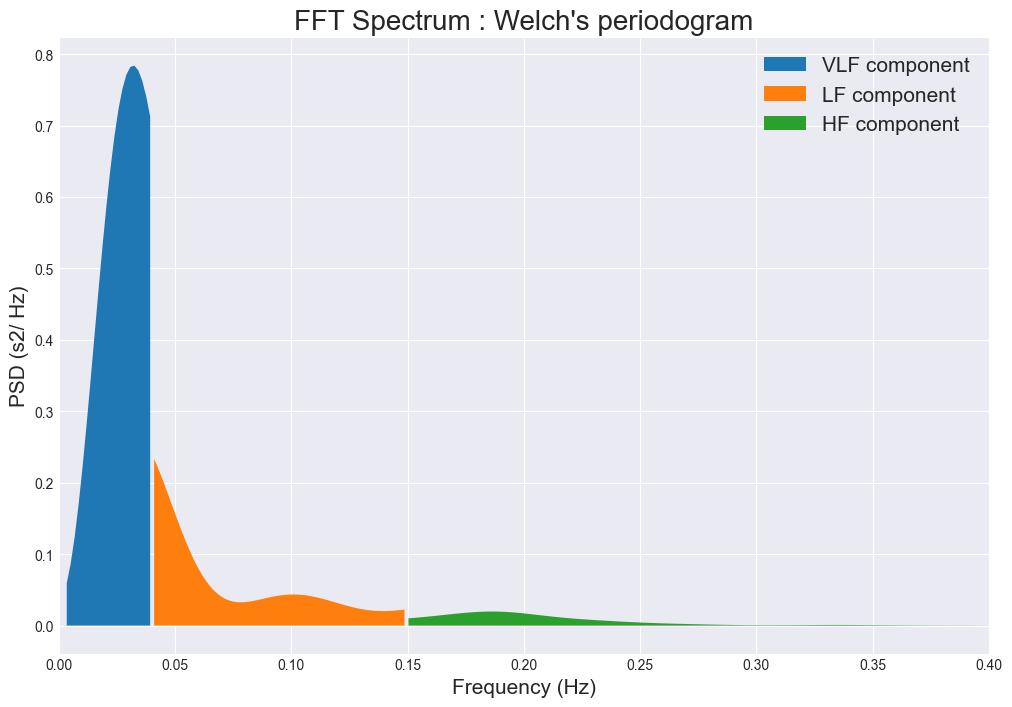

In [20]:
 # * Computing HRV

epochs_features = []
for epoch in epochs_nni_ms_processed: # Determines the HRV features of each epoch
    features = hrvanalysis.extract_features.get_frequency_domain_features(epoch)
    epochs_features.append(features)

def visualize_epoch_feature(epoch_idx): # Function for visualizing the HRV features of an epoch
    df = pd.DataFrame(list(epochs_features[epoch_idx].items()), columns = ['Key', 'Value'])
    print(f"Epoch Index: {epoch_idx}")
    print(f"Epoch Number: {epoch_idx + 1} / {num_epochs}")
    display(df)

    hrvanalysis.plot.plot_psd(epochs_nni_ms_processed[0], method = 'welch')

visualize_epoch_feature(epoch_idx = 0)

In [21]:
 # * Storing Features

LF = [epoch_feature["lf"] for epoch_feature in epochs_features]
HF = [epoch_feature["hf"] for epoch_feature in epochs_features]
LF_HF = [epoch_feature["lf_hf_ratio"] for epoch_feature in epochs_features]
LF_nu = [epoch_feature["lfnu"] for epoch_feature in epochs_features]
HF_nu = [epoch_feature["hfnu"] for epoch_feature in epochs_features]
TP = [epoch_feature["total_power"] for epoch_feature in epochs_features]

In [22]:
 # * Labeling DoA 

epochs_BIS_value_idx = epochs_processed.events[:, 0] # Finds the indices of BIS events associated with the remaining (undropped) epochs
epochs_BIS_value = BIS[epochs_BIS_value_idx] # Determines the BIS values associated with these epochs
epochs_BIS_time = time[epochs_BIS_value_idx] # Determines the time onset of these BIS values

# Classfies the DoA using the BIS values into Deep, Moderate, and Light classes
DoA_classification = [
    (epochs_BIS_value >= 0) & (epochs_BIS_value <= 40),
    (epochs_BIS_value >= 40) & (epochs_BIS_value <= 60),
    (epochs_BIS_value >= 60) & (epochs_BIS_value <= 100)]
DoA_labels = ['Deep', 'Moderate', 'Light']
DoA = np.select(DoA_classification, DoA_labels)

In [23]:
 # * Mapping DoA

# Maps Light as 0, Moderate as 1, and Deep as 2
DoA_mapping = {"Light": 0, "Moderate": 1, "Deep": 2}
DoA_values = []
for value in DoA:
    DoA_values.append(DoA_mapping[value])

# Saving Data

In [24]:
 # * Creating DataFrame

df_features = pd.DataFrame({
    'Time' : epochs_BIS_time,
    'DoA' : DoA,
    'DoA Value' : DoA_values,
    'BIS Value' : epochs_BIS_value,
    'LF': LF,
    'HF': HF,
    'LF_HF': LF_HF,
    'LF_nu': LF_nu,
    'HF_nu': HF_nu,
    'TP': TP
}) 

df_features.reset_index(drop = True, inplace = True)
display(df_features)

,Time,DoA,DoA Value,BIS Value,LF,HF,LF_HF,LF_nu,HF_nu,TP
0,62.164062,Light,0,96.500000,441.434921,241.237068,1.829880,64.662814,35.337186,1129.238685
1,63.164062,Light,0,94.500000,452.854653,243.833307,1.857230,65.001073,34.998927,1167.332969
2,64.164062,Light,0,94.500000,473.537364,248.500942,1.905576,65.583413,34.416587,1269.376660
3,65.164062,Light,0,94.500000,481.948069,251.377103,1.917231,65.720923,34.279077,1331.978063
4,66.164062,Light,0,93.599998,488.138690,252.550944,1.932833,65.903270,34.096730,1395.918799
...,...,...,...,...,...,...,...,...,...,...
2153,3601.179688,Moderate,1,58.000000,23.459648,3.387824,6.924696,87.381219,12.618781,50.798640
2154,3602.179688,Moderate,1,59.200001,22.643505,3.521987,6.429185,86.539573,13.460427,49.182323
2155,3603.179688,Light,0,61.500000,21.764018,3.622433,6.008121,85.730840,14.269160,47.503294
2156,3604.179688,Light,0,61.099998,20.893296,3.759595,5.557326,84.749881,15.250119,46.164067


In [25]:
 # * Saving to .csv

save_path = os.path.join(os.getcwd(), f'Case_{case}.csv')
df_features.to_csv(save_path, index = False)